# architecture-18 ( Basic Classification ) v-2

## What's new:

1- Add


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input, Reshape
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [3]:
# 1- Load and Scaling Features

# Load and preprocess
df = pd.read_csv('datasets-18/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [4]:

# 2- Label trend reversals (example: a simplistic method)

def label_trend_reversals(prices, window=5, threshold=0.0005):
    prices = np.asarray(prices)
    labels = []

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)

        if future_mean > past_mean * (1 + threshold):
            labels.append(1)  # potential buy
        elif future_mean < past_mean * (1 - threshold):
            labels.append(2)  # potential sell
        else:
            labels.append(0)  # no signal

    # Padding the end with zeros
    labels += [0] * window
    return labels

# Apply labeling on cleaned DataFrame
df['Label'] = label_trend_reversals(df['CLOSE'].values, window=10, threshold=0.001)


In [5]:
# 3- Prepare Sequences

SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i - SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i + FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")  # Debug info

X shape: (55013, 60, 5), y shape: (55013, 10)


In [6]:
# 4- Split dataset

# Reserve only the last sample for testing
X_train = X[:-1]
y_train = y[:-1]  # Shape: (samples, 10)

X_test = X[-1:]   # Shape: (1, 60, 5)
y_test = y[-1:]   # Shape: (1, 10), still in integer form for now

print(f"Train X: {X_train.shape}, y: {y_train.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")

Train X: (55012, 60, 5), y: (55012, 10)
Test X: (1, 60, 5), y: (1, 10)


In [7]:
# 5- One-hot encode each timestep's class (3 classes → depth = 3)

# One-hot encode training labels
y_train_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])

# One-hot encode test labels (for model.evaluate or model.predict accuracy)
y_test_onehot = np.array([to_categorical(row, num_classes=3) for row in y_test])

# Debug shapes
print(f"y_train_onehot shape: {y_train_onehot.shape}")  # (samples, 10, 3)
print(f"y_test_onehot shape: {y_test_onehot.shape}")    # (1, 10, 3)


y_train_onehot shape: (55012, 10, 3)
y_test_onehot shape: (1, 10, 3)


In [8]:
# 6- Build LSTM Classification Model

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),  # (60, 5)
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    Reshape((FORECAST_HORIZON, 3))  # Final output: (10, 3)
])


I0000 00:00:1754032326.974701    4389 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2384 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [9]:
# 7- Compile model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_2_accuracy')
    ]
)



In [10]:
# 8- Fit model

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train_onehot,
    epochs=50,                   # adjust based on convergence
    batch_size=64,
    validation_split=0.1,
    shuffle=False,               # Important: keep time order!
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


I0000 00:00:1754032334.133679    4454 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - categorical_accuracy: 0.3887 - loss: 1.0724 - top_2_accuracy: 0.7764 - val_categorical_accuracy: 0.4067 - val_loss: 1.0496 - val_top_2_accuracy: 0.8081
Epoch 2/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.3902 - loss: 1.0645 - top_2_accuracy: 0.7830 - val_categorical_accuracy: 0.4069 - val_loss: 1.0502 - val_top_2_accuracy: 0.8081
Epoch 3/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.3901 - loss: 1.0642 - top_2_accuracy: 0.7830 - val_categorical_accuracy: 0.4067 - val_loss: 1.0501 - val_top_2_accuracy: 0.8081
Epoch 4/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.3895 - loss: 1.0643 - top_2_accuracy: 0.7830 - val_categorical_accuracy: 0.4067 - val_loss: 1.0509 - val_top_2_accuracy: 0.8081
Epoch 5/50
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.3887 - loss: 1.0642 - top_2_accuracy: 0.7830 - val_categorical_accuracy: 0.4067 - val_loss: 1.0508 - val_top_

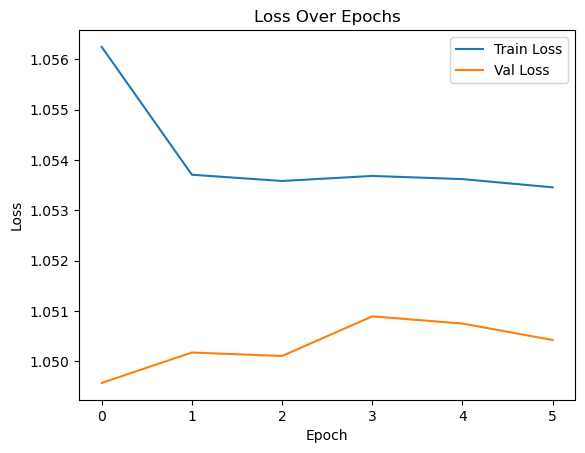

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
# 9- Load the last 60 candles from a CSV file

# Load and clean
input_df = pd.read_csv('datasets-18/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv', sep='\t')
input_df.dropna(inplace=True)

input_df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Add datetime
input_df['DATETIME'] = pd.to_datetime(input_df['DATE'] + ' ' + input_df['TIME'])

# Scale
input_features = input_df[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']]
input_scaled = scaler.transform(input_features)
input_sequence = np.expand_dims(input_scaled, axis=0)  # (1, 60, 5)

# Predict
pred_probs = model.predict(input_sequence)  # shape: (1, 10, 3)
pred_classes = np.argmax(pred_probs[0], axis=1)
print("Predicted Classes:", pred_classes)  # 0=no signal, 1=buy, 2=sell

# Timestamps for forecast
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                   periods=FORECAST_HORIZON, freq='h')

# Output DataFrame
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted Classes: [1 1 1 1 1 1 1 1 1 1]
             DATETIME  forecast_class label
0 2024-05-07 15:00:00               1   buy
1 2024-05-07 16:00:00               1   buy
2 2024-05-07 17:00:00               1   buy
3 2024-05-07 18:00:00               1   buy
4 2024-05-07 19:00:00               1   buy
5 2024-05-07 20:00:00               1   buy
6 2024-05-07 21:00:00               1   buy
7 2024-05-07 22:00:00               1   buy
8 2024-05-07 23:00:00               1   buy
9 2024-05-08 00:00:00               1   buy


# plot section

In [13]:
# 10- Plot section

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os
import pandas as pd

# 10-1 PARAMETERS
csv1_path = 'datasets-18/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-18/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Write a suitable title.'
output_plot_path = None  # e.g., 'output.png'

# 10-2 LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None
# 10-3 Generate forecast timestamps ===
# Start 1 hour after the last actual candle
last_timestamp = input_df['DATETIME'].iloc[-1]
forecast_datetimes = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=FORECAST_HORIZON , freq='h')

# 10-4 Create predicted_df with forecasted trend reversals
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': pred_classes
})

# 10-5 Optional: Add labels for plotting
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None

predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)


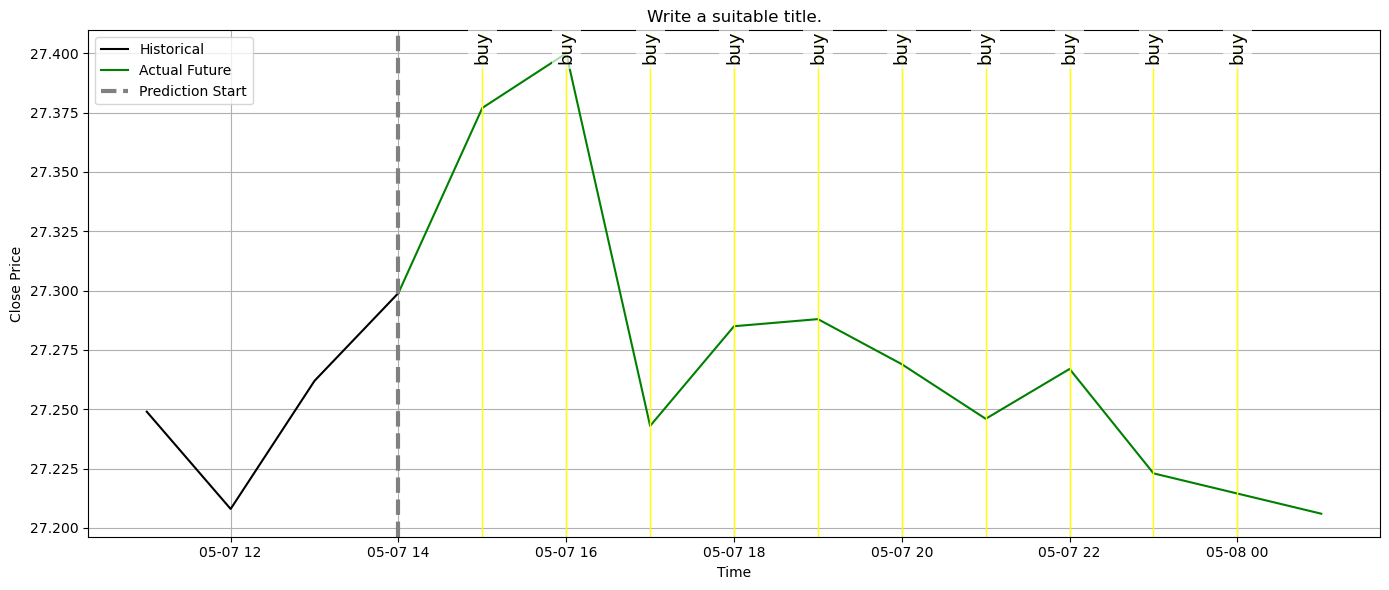

In [14]:
# 10-6 PLOT

forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [15]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy, final_test_mae = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')